In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Data preparing

In [32]:
#Read stock data use pandas_datareader.data from web
# Get Stock Data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [33]:
# Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data
print(X1)
print(X2)
print(X3)

Attributes   Adj Close            
Symbols          GOOGL         IBM
Date                              
2017-10-03   48.604000  110.628021
2017-10-04   48.339001  110.401939
2017-10-05   49.259499  110.582809
2017-10-06   49.681999  110.401939
2017-10-09   49.615501  111.087791
...                ...         ...
2022-09-27   97.500000  121.739998
2022-09-28  100.050003  122.760002
2022-09-29   97.419998  121.629997
2022-09-30   95.650002  118.809998
2022-10-03   97.040001  119.724998

[1259 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-10-04   112.84   1.3268
2017-10-05   112.74   1.3132
2017-10-06   112.68   1.3063
2017-10-09      NaN      NaN
2017-10-10   112.15   1.3215
...             ...      ...
2022-09-19   143.34   1.1403
2022-09-20   143.64   1.1405
2022-09-21   144.14   1.1330
2022-09-22   142.16   1.1269
2022-09-23   143.18   1.0921

[1298 rows x 2 columns]
              SP500      DJIA  VIXCLS
DATE                                 
2017-10

In [34]:
#Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
sX1 = standard_scaler.fit_transform(X1.values)
sX2 = standard_scaler.fit_transform(X2.values)
sX3 = standard_scaler.fit_transform(X3.values)
print(type(sX1))
sX1

<class 'numpy.ndarray'>


array([[-1.11088344, -0.45255836],
       [-1.11930087, -0.47342409],
       [-1.09006224, -0.45673108],
       ...,
       [ 0.43970446,  0.56284481],
       [ 0.38348241,  0.30257914],
       [ 0.42763425,  0.38702714]])

In [35]:
sX1 = pd.DataFrame(index = X1.index,data = sX1,columns=X1.columns)
sX2 = pd.DataFrame(index = X2.index,data = sX2,columns=X2.columns)
sX3 = pd.DataFrame(index = X3.index,data = sX3,columns=X3.columns)
sX1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-10-03 -1.110883 -0.452558
2017-10-04 -1.119301 -0.473424
2017-10-05 -1.090062 -0.456731
2017-10-06 -1.076642 -0.473424
2017-10-09 -1.078754 -0.410125
...              ...       ...
2022-09-27  0.442246  0.572997
2022-09-28  0.523244  0.667136
2022-09-29  0.439704  0.562845
2022-09-30  0.383482  0.302579
2022-10-03  0.427634  0.387027

[1259 rows x 2 columns]

In [36]:
X1['Adj Close']

Symbols,GOOGL,IBM
Date,,
2017-10-03,48.604000,110.628021
2017-10-04,48.339001,110.401939
2017-10-05,49.259499,110.582809
2017-10-06,49.681999,110.401939
2017-10-09,49.615501,111.087791
...,...,...
2022-09-27,97.500000,121.739998
2022-09-28,100.050003,122.760002
2022-09-29,97.419998,121.629997


In [37]:
# Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง return_period วัน
return_period = 1 #predict 1 วันข้างหน้า
Y = base.shift(-return_period)
X4_3DT = base.diff(3*return_period).shift(-3*return_period)
X4_6DT = base.diff(6*return_period).shift(-6*return_period)
X4_12DT = base.diff(12*return_period).shift(-12*return_period)
X4 = pd.concat([X4_3DT, X4_6DT, X4_12DT], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

# Forming Dataset
X = pd.concat([sX1, sX2, sX3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)
print(type(dataset))


<class 'pandas.core.frame.DataFrame'>


In [38]:
dataset.dropna(inplace=True)
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-04,71.385201,-1.119301,-0.473424,0.107769,0.278181,-1.241406,-1.454791,-1.266307,0.194006,0.187955,0.207123
2017-10-05,71.413376,-1.090062,-0.456731,0.095187,0.051422,-1.220499,-1.427032,-1.317006,-0.016300,0.080042,0.098646
2017-10-06,71.685883,-1.076642,-0.473424,0.087638,-0.063625,-1.224496,-1.427452,-1.264002,0.000131,0.095461,0.098649
2017-10-10,71.808029,-1.085917,-0.332910,0.020953,0.189811,-1.222585,-1.413539,-1.214455,0.128284,0.056327,0.065071
2017-10-11,72.465805,-1.057568,-0.394125,0.046117,0.181475,-1.215874,-1.403238,-1.240957,0.133217,0.076484,0.488649
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-09,266.649994,0.859941,1.260579,3.832036,-2.502954,0.990295,0.861158,0.250062,-2.209060,-2.616591,-2.717579
2022-09-12,251.990005,0.866612,1.396249,3.828261,-2.334552,1.053104,0.917196,0.374506,-3.787972,-3.154196,-2.491272
2022-09-13,252.220001,0.658876,1.081531,4.066061,-2.626338,0.793813,0.605712,0.766273,-1.336551,-1.745827,-1.475184
2022-09-14,245.380005,0.680475,1.122140,3.893688,-2.562979,0.813246,0.613063,0.638373,-1.415234,-1.518670,-1.917719


In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1229 entries, 2017-10-04 to 2022-09-15
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1229 non-null   float64
 1   (Adj Close, GOOGL)  1229 non-null   float64
 2   (Adj Close, IBM)    1229 non-null   float64
 3   DEXJPUS             1229 non-null   float64
 4   DEXUSUK             1229 non-null   float64
 5   SP500               1229 non-null   float64
 6   DJIA                1229 non-null   float64
 7   VIXCLS              1229 non-null   float64
 8   MSFT_3DT            1229 non-null   float64
 9   MSFT_6DT            1229 non-null   float64
 10  MSFT_12DT           1229 non-null   float64
dtypes: float64(11)
memory usage: 115.2 KB


In [40]:
Y = pd.DataFrame(dataset[dataset.columns[0]].reset_index(drop=True))
X = pd.DataFrame(dataset[dataset.columns[1:]].reset_index(drop=True))
print(Y)
print(X)

       Adj Close
            MSFT
0      71.385201
1      71.413376
2      71.685883
3      71.808029
4      72.465805
...          ...
1224  266.649994
1225  251.990005
1226  252.220001
1227  245.380005
1228  244.740005

[1229 rows x 1 columns]
      (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK     SP500  \
0              -1.119301         -0.473424  0.107769  0.278181 -1.241406   
1              -1.090062         -0.456731  0.095187  0.051422 -1.220499   
2              -1.076642         -0.473424  0.087638 -0.063625 -1.224496   
3              -1.085917         -0.332910  0.020953  0.189811 -1.222585   
4              -1.057568         -0.394125  0.046117  0.181475 -1.215874   
...                  ...               ...       ...       ...       ...   
1224            0.859941          1.260579  3.832036 -2.502954  0.990295   
1225            0.866612          1.396249  3.828261 -2.334552  1.053104   
1226            0.658876          1.081531  4.066061 -2.626338  0.7938

In [41]:
X.corr()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.603660,0.393266,0.244286,0.985346,0.960352,0.145096,-0.060370,-0.084786,-0.114582
"(Adj Close, IBM)",0.603660,1.000000,0.567784,0.192431,0.611634,0.663627,-0.285487,-0.094267,-0.144566,-0.191502
DEXJPUS,0.393266,0.567784,1.000000,-0.427531,0.357720,0.347752,0.069241,-0.101157,-0.151651,-0.217975
DEXUSUK,0.244286,0.192431,-0.427531,1.000000,0.254743,0.303752,-0.326826,0.026000,0.043653,0.072561
SP500,0.985346,0.611634,0.357720,0.254743,1.000000,0.986183,0.098877,-0.068540,-0.098295,-0.134585
DJIA,0.960352,0.663627,0.347752,0.303752,0.986183,1.000000,-0.019465,-0.070349,-0.100861,-0.135495
VIXCLS,0.145096,-0.285487,0.069241,-0.326826,0.098877,-0.019465,1.000000,0.054788,0.075365,0.099628
MSFT_3DT,-0.060370,-0.094267,-0.101157,0.026000,-0.068540,-0.070349,0.054788,1.000000,0.688492,0.494451
MSFT_6DT,-0.084786,-0.144566,-0.151651,0.043653,-0.098295,-0.100861,0.075365,0.688492,1.000000,0.684222
MSFT_12DT,-0.114582,-0.191502,-0.217975,0.072561,-0.134585,-0.135495,0.099628,0.494451,0.684222,1.000000


In [42]:
lower = pd.DataFrame(np.tril(X.corr(),-1),columns = X.columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.9)]
to_drop


[('Adj Close', 'GOOGL'), 'SP500']

In [43]:
X.drop(columns=to_drop,inplace=True)


In [44]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.473424,0.107769,0.278181,-1.454791,-1.266307,0.194006,0.187955,0.207123
1,-0.456731,0.095187,0.051422,-1.427032,-1.317006,-0.016300,0.080042,0.098646
2,-0.473424,0.087638,-0.063625,-1.427452,-1.264002,0.000131,0.095461,0.098649
3,-0.332910,0.020953,0.189811,-1.413539,-1.214455,0.128284,0.056327,0.065071
4,-0.394125,0.046117,0.181475,-1.403238,-1.240957,0.133217,0.076484,0.488649
...,...,...,...,...,...,...,...,...
1224,1.260579,3.832036,-2.502954,0.861158,0.250062,-2.209060,-2.616591,-2.717579
1225,1.396249,3.828261,-2.334552,0.917196,0.374506,-3.787972,-3.154196,-2.491272
1226,1.081531,4.066061,-2.626338,0.605712,0.766273,-1.336551,-1.745827,-1.475184
1227,1.122140,3.893688,-2.562979,0.613063,0.638373,-1.415234,-1.518670,-1.917719


# train

In [45]:
#shuffle spilt
# Rseed = 55
# x_train_set , x_test, y_train_set , y_test = train_test_split(X,Y,test_size= 0.3,random_state= Rseed)
# x_train,x_validate,y_train,y_validate = train_test_split(x_train_set,y_train_set,test_size=0.3 ,random_state= Rseed)
from math import ceil, floor
#test_size =  ceil(0.3 * len( X ))
train_size = floor(0.7 * len( X ))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

print(train_size)


860


## Kfold

In [46]:
# Cross Validation Model
# set k-fold crossvalidation with shuffle
num_fold = 4
seed = 500
kfold = KFold(n_splits=num_fold, shuffle = True, random_state=seed)

## SVR train

In [47]:
import warnings
warnings.filterwarnings('ignore')
# Model selection
model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)
#c_val ลองอย่างน้อย 3 ค่า [0.1, 1, 10, 100]
lst = [0.1, 1, 10, 100]
c_val = 0
AVG_Linear_Model =[]
AVG_SVR_linear =[]
AVG_SVR_rbf = []
AVG_SVR_poly = []
for i in lst:
    c_val = i
    svr_lin  = SVR(kernel='linear', C=c_val)
    svr_rbf  = SVR(kernel='rbf'   , C=c_val, gamma=0.01)
    svr_poly = SVR(kernel='poly'  , C=c_val, degree=2)
    
    #Calculate accuracy score for each model
    score_LM    =  cross_val_score(model_LM, X_train, Y_train, cv=kfold)
    score_lin   =  cross_val_score(svr_lin, X_train, Y_train, cv=kfold)
    score_rbf   =  cross_val_score(svr_rbf, X_train, Y_train, cv=kfold)
    score_poly  =  cross_val_score(svr_poly, X_train, Y_train, cv=kfold)

    # View score k-fold
    # Valication score comparison
    score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':score_poly})
    score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
                                'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
    print(score)
    print(score_mean)

    #display( plot ( score ))
    AVG_Linear_Model.append(score_LM.mean())
    AVG_SVR_linear.append(score_lin.mean())
    AVG_SVR_rbf.append(score_rbf.mean())
    AVG_SVR_poly.append(score_poly.mean())


   Linear Model  SVR_linear   SVR_rbf  SVR_poly
0      0.896255    0.577119  0.018711  0.113743
1      0.903978    0.539056  0.000922  0.094584
2      0.879188    0.515312 -0.007959  0.099898
3      0.905045    0.456854 -0.115904 -0.066761
   AVG Linear Model  AVG SVR_linear  AVG SVR_rbf  AVG SVC_poly
0          0.896117        0.522085    -0.026057      0.060366
   Linear Model  SVR_linear   SVR_rbf  SVR_poly
0      0.896255    0.876777  0.177733  0.492646
1      0.903978    0.897765  0.139673  0.461029
2      0.879188    0.860802  0.138966  0.468082
3      0.905045    0.888732  0.026358  0.339344
   AVG Linear Model  AVG SVR_linear  AVG SVR_rbf  AVG SVC_poly
0          0.896117        0.881019     0.120683      0.440275
   Linear Model  SVR_linear   SVR_rbf  SVR_poly
0      0.896255    0.884148  0.797600  0.878854
1      0.903978    0.900830  0.788089  0.874663
2      0.879188    0.865343  0.765264  0.853198
3      0.905045    0.895390  0.730434  0.844609
   AVG Linear Model  AVG SVR

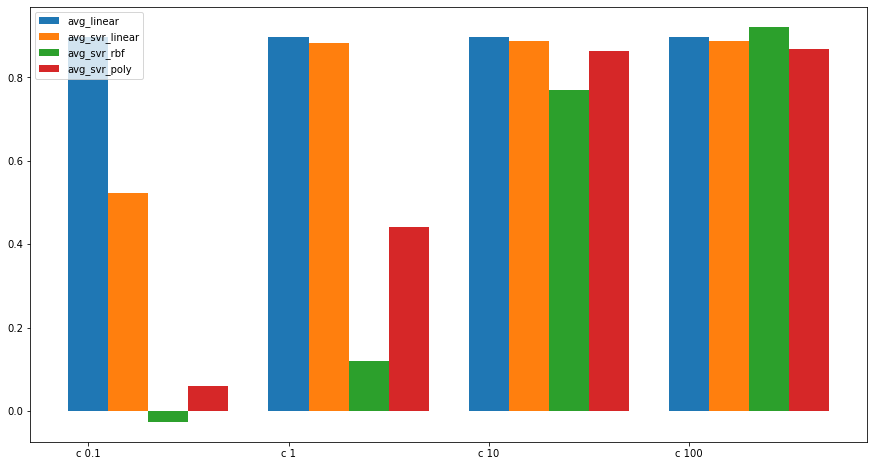

In [48]:
cvall = ['c 0.1','c 1','c 10','c 100']
plt.figure(figsize =(15, 8))
X_axis = np.arange(len(AVG_Linear_Model))
plt.bar(X_axis , AVG_Linear_Model, 0.2, label = 'avg_linear')
plt.bar(X_axis + 0.2, AVG_SVR_linear, 0.2, label = 'avg_svr_linear')
plt.bar(X_axis + 0.4, AVG_SVR_rbf, 0.2, label = 'avg_svr_rbf')
plt.bar(X_axis + 0.6, AVG_SVR_poly, 0.2, label = 'avg_svr_poly')
plt.xticks(X_axis, cvall)

plt.legend()
plt.show()

## Score

In [49]:
print(score_LM)
print(score_lin)
print(score_rbf)
print(score_poly)

[0.89625548 0.90397806 0.87918837 0.90504463]
[0.88509339 0.90071135 0.86492759 0.89551782]
[0.92431562 0.92587112 0.90786261 0.92668925]
[0.89043599 0.86455451 0.86578228 0.85312399]


In [50]:
# View score k-fold
# Valication score comparison
score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly': score_poly})
score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
                            'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
print(score)
print(score_mean)
#display( plot ( score ))

   Linear Model  SVR_linear   SVR_rbf  SVR_poly
0      0.896255    0.885093  0.924316  0.890436
1      0.903978    0.900711  0.925871  0.864555
2      0.879188    0.864928  0.907863  0.865782
3      0.905045    0.895518  0.926689  0.853124
   AVG Linear Model  AVG SVR_linear  AVG SVR_rbf  AVG SVC_poly
0          0.896117        0.886563     0.921185      0.868474


In [51]:
# Predict all models ( LM, SVR_linear, SVR_rbf, SVR Poly )
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
# Model prediction performance evaluation for all model ( LM, SVR_linear, SVR_rbf, SVR Poly )
#MSE 
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
#R2
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print(LM_MSE)
print(LM_r2)

4469.6833415730825
-5.278359182489573


# Find all

In [52]:
c_val = 10
svr_lin =   SVR(kernel='linear',   C=c_val)
svr_rbf =   SVR(kernel='rbf',      C=c_val, gamma=0.01)
svr_poly =  SVR(kernel='poly',     C=c_val, degree=2)

LM_pred      =  model_LM.fit(X_train, Y_train).predict(X_test)
svr_lin_pred =  svr_lin.fit(X_train,Y_train).predict(X_test)
svr_rbf_pred =  svr_rbf.fit(X_train,Y_train).predict(X_test)
svr_poly_pred = svr_poly.fit(X_train,Y_train).predict(X_test)
# X_test.reset_index(inplace = True)
# X_test.drop(columns = [X_test.columns[0]],inplace = True)
# print(len(LM_pred))
# print(X_test)

In [53]:
X_test.columns

Index([('Adj Close', 'IBM'),            'DEXJPUS',            'DEXUSUK',
                     'DJIA',             'VIXCLS',           'MSFT_3DT',
                 'MSFT_6DT',          'MSFT_12DT'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


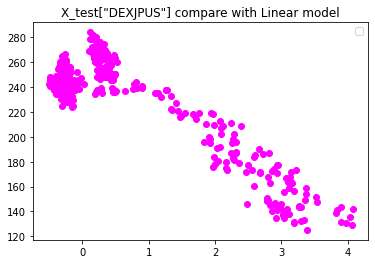

In [54]:
plt.scatter(X_test["DEXJPUS"],LM_pred, c='magenta')
plt.title('X_test["DEXJPUS"] compare with Linear model')
plt.legend()
plt.show()

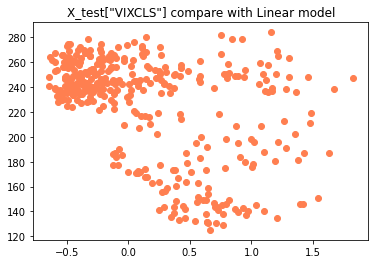

In [55]:
plt.scatter(X_test["VIXCLS"],LM_pred, c='coral')
plt.title('X_test["VIXCLS"] compare with Linear model')
plt.show()


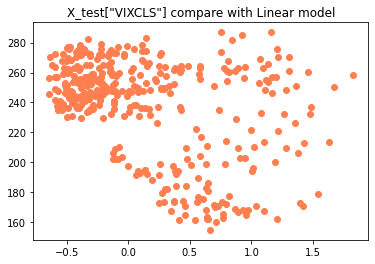

In [56]:
plt.scatter(X_test["VIXCLS"],svr_lin_pred, c='coral')
plt.title('X_test["VIXCLS"] compare with Linear model')
plt.show()

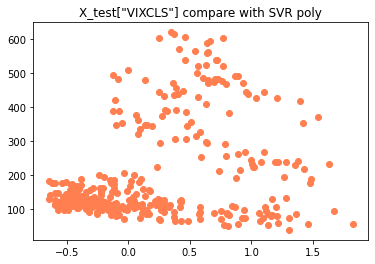

In [57]:
plt.scatter(X_test["VIXCLS"],svr_poly_pred, c='coral')
plt.title('X_test["VIXCLS"] compare with SVR poly')
plt.show()


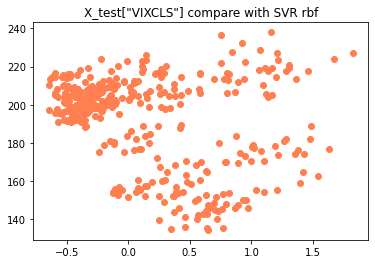

In [58]:
plt.scatter(X_test["VIXCLS"],svr_rbf_pred, c='coral')
plt.title('X_test["VIXCLS"] compare with SVR rbf')
plt.show()

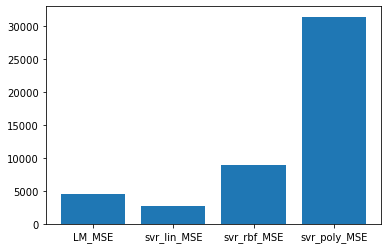

In [59]:
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
LM_r2 = metrics.r2_score(Y_test, LM_pred)
# print (LM_MSE)
# print(LM_r2)

svr_lin_MSE = metrics.mean_squared_error(Y_test, svr_lin_pred)
svr_lin_r2 = metrics.r2_score(Y_test, svr_lin_pred)
# print (svr_lin_MSE)
# print(svr_lin_r2)

svr_rbf_MSE = metrics.mean_squared_error(Y_test, svr_rbf_pred)
svr_rbf_r2 = metrics.r2_score(Y_test, svr_rbf_pred)
# print (svr_rbf_MSE)
# print(svr_rbf_r2)

svr_poly_MSE = metrics.mean_squared_error(Y_test, svr_poly_pred)
svr_poly_r2 = metrics.r2_score(Y_test, svr_poly_pred)
# print (svr_poly_MSE)
# print(svr_poly_r2)

plt.bar(["LM_MSE","svr_lin_MSE","svr_rbf_MSE","svr_poly_MSE"],[LM_MSE,svr_lin_MSE,svr_rbf_MSE,svr_poly_MSE])
plt.show()

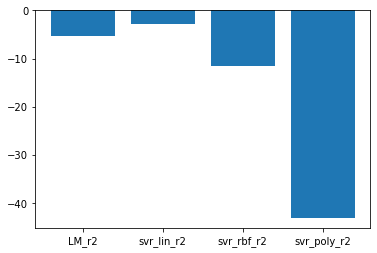

In [60]:
plt.bar(["LM_r2","svr_lin_r2","svr_rbf_r2","svr_poly_r2"],[LM_r2,svr_lin_r2,svr_rbf_r2,svr_poly_r2])
plt.show()